In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np 
from torchvision.utils import make_grid
import imageio

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
import importlib
try: 
    importlib.reload(utils)
    importlib.reload(generators)
    importlib.reload(trainers)
    print("libs reloaded")
except:
    import generators 
    import trainers
    import utils
    print("libs imported")

VAE = generators.VAE
TrainerMaskVAE = trainers.TrainerMaskVAE

libs imported


# Mask VAE

In [4]:
WORKING_DIR = Path(r"C:\Users\marti\OneDrive - TU Eindhoven\Documenten\Master\Q3\Capita Selecta\Project")
DATA_DIR = WORKING_DIR / "Data"
PROGRESS_DIR_VAE = WORKING_DIR / "progress_vaemask"
PROGRESS_DIR_VAE.mkdir(parents=True, exist_ok=True)
TENSORBOARD_LOGDIR = "vae_runs"

N = 15
NO_VALIDATION_PATIENTS = 3
train_size = N-NO_VALIDATION_PATIENTS
seed = 0
IMAGE_SIZE = [64,64]

Z_DIM = 16

BATCH_SIZE = 32
N_EPOCHS = 200
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-3
EARLY_STOPPING = False

exp = str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + '_zdim_final'
EXPERIMENT_DIR = PROGRESS_DIR_VAE / exp
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

OPTIMIZER = lambda parameters, lr : torch.optim.NAdam(parameters, lr=lr, betas=(0.5,0.999))

# loewr epochs increases weights faster
KLD_ANNEALING_EPOCHS = 25

In [10]:
def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

utils.remove_empty_masks(DATA_DIR)

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=train_size)

partition = {
    "train": train_indx,
    "validation": valid_indx,
}

#specify data augmentation
transform = transforms.Compose([
     transforms.RandomRotation((-6.,+6.), interpolation=transforms.InterpolationMode.NEAREST),
     transforms.RandomResizedCrop((64,64), scale=(0.8,1.), ratio=(1,1), interpolation=transforms.InterpolationMode.NEAREST)
 ])

# load training data and create DataLoader with batching and shuffling
train_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE,  empty_masks = True, transform = transform)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE, empty_masks = True)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)
    
train_set.labels = train_set.labels[:,0:1]
valid_set.labels = valid_set.labels[:,0:1]

In [6]:
vae_model = VAE(spade=False).to(device)

optimizer = OPTIMIZER(vae_model.parameters(), lr=LEARNING_RATE)
vae_trainer = TrainerMaskVAE(
    net=vae_model,
    optimizer=optimizer,
    kld_annealing_epochs=KLD_ANNEALING_EPOCHS,
    progress_dir=EXPERIMENT_DIR,
    train_loader=train_loader,
    valid_loader=valid_loader,
    CHECKPOINTS_DIR=EXPERIMENT_DIR,
    device=device,
    early_stopping=EARLY_STOPPING
)

In [ ]:
vae_trainer.train(N_EPOCHS, lambda_lr=lambda_lr)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #000: Rec_Loss/train = 0.608, KLD/train = 4.476 | Rec_Loss/valid = 0.551, KLD/valid = 12.424


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #001: Rec_Loss/train = 0.467, KLD/train = 4.972 | Rec_Loss/valid = 0.395, KLD/valid = 2.318


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #002: Rec_Loss/train = 0.387, KLD/train = 2.519 | Rec_Loss/valid = 0.481, KLD/valid = 3.052


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #003: Rec_Loss/train = 0.361, KLD/train = 2.000 | Rec_Loss/valid = 0.314, KLD/valid = 1.274


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #004: Rec_Loss/train = 0.302, KLD/train = 1.538 | Rec_Loss/valid = 0.293, KLD/valid = 1.224


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #005: Rec_Loss/train = 0.306, KLD/train = 1.214 | Rec_Loss/valid = 0.282, KLD/valid = 0.809


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #006: Rec_Loss/train = 0.264, KLD/train = 0.689 | Rec_Loss/valid = 0.218, KLD/valid = 0.442


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #007: Rec_Loss/train = 0.274, KLD/train = 0.646 | Rec_Loss/valid = 0.252, KLD/valid = 0.389


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #008: Rec_Loss/train = 0.261, KLD/train = 0.403 | Rec_Loss/valid = 0.308, KLD/valid = 0.350


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #009: Rec_Loss/train = 0.230, KLD/train = 0.253 | Rec_Loss/valid = 0.272, KLD/valid = 0.301


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #010: Rec_Loss/train = 0.492, KLD/train = 5.829 | Rec_Loss/valid = 0.494, KLD/valid = 0.896


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #011: Rec_Loss/train = 0.375, KLD/train = 0.826 | Rec_Loss/valid = 0.304, KLD/valid = 0.429


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #012: Rec_Loss/train = 0.268, KLD/train = 0.261 | Rec_Loss/valid = 0.304, KLD/valid = 0.129


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #013: Rec_Loss/train = 0.260, KLD/train = 0.172 | Rec_Loss/valid = 0.293, KLD/valid = 0.141


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #014: Rec_Loss/train = 0.241, KLD/train = 0.139 | Rec_Loss/valid = 0.253, KLD/valid = 0.087


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #015: Rec_Loss/train = 0.243, KLD/train = 0.108 | Rec_Loss/valid = 0.285, KLD/valid = 0.068


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #016: Rec_Loss/train = 0.223, KLD/train = 0.091 | Rec_Loss/valid = 0.252, KLD/valid = 0.068


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #017: Rec_Loss/train = 0.233, KLD/train = 0.091 | Rec_Loss/valid = 0.255, KLD/valid = 0.074


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #018: Rec_Loss/train = 0.212, KLD/train = 0.079 | Rec_Loss/valid = 0.227, KLD/valid = 0.053


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #019: Rec_Loss/train = 0.199, KLD/train = 0.069 | Rec_Loss/valid = 0.221, KLD/valid = 0.060


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #020: Rec_Loss/train = 0.206, KLD/train = 0.077 | Rec_Loss/valid = 0.220, KLD/valid = 0.050


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #021: Rec_Loss/train = 0.206, KLD/train = 0.069 | Rec_Loss/valid = 0.230, KLD/valid = 0.068


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #022: Rec_Loss/train = 0.202, KLD/train = 0.066 | Rec_Loss/valid = 0.219, KLD/valid = 0.052


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #023: Rec_Loss/train = 0.192, KLD/train = 0.062 | Rec_Loss/valid = 0.276, KLD/valid = 0.054


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #024: Rec_Loss/train = 0.199, KLD/train = 0.063 | Rec_Loss/valid = 0.253, KLD/valid = 0.050


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #025: Rec_Loss/train = 0.189, KLD/train = 0.062 | Rec_Loss/valid = 0.224, KLD/valid = 0.047


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #026: Rec_Loss/train = 0.193, KLD/train = 0.065 | Rec_Loss/valid = 0.230, KLD/valid = 0.047


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #027: Rec_Loss/train = 0.190, KLD/train = 0.062 | Rec_Loss/valid = 0.210, KLD/valid = 0.049


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #028: Rec_Loss/train = 0.198, KLD/train = 0.071 | Rec_Loss/valid = 0.242, KLD/valid = 0.056


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #029: Rec_Loss/train = 0.184, KLD/train = 0.060 | Rec_Loss/valid = 0.201, KLD/valid = 0.051


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #030: Rec_Loss/train = 0.182, KLD/train = 0.059 | Rec_Loss/valid = 0.198, KLD/valid = 0.051


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #031: Rec_Loss/train = 0.182, KLD/train = 0.061 | Rec_Loss/valid = 0.231, KLD/valid = 0.050


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #032: Rec_Loss/train = 0.182, KLD/train = 0.062 | Rec_Loss/valid = 0.205, KLD/valid = 0.052


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #033: Rec_Loss/train = 0.181, KLD/train = 0.062 | Rec_Loss/valid = 0.203, KLD/valid = 0.046


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #034: Rec_Loss/train = 0.176, KLD/train = 0.061 | Rec_Loss/valid = 0.210, KLD/valid = 0.045


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #035: Rec_Loss/train = 0.180, KLD/train = 0.059 | Rec_Loss/valid = 0.193, KLD/valid = 0.049


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #036: Rec_Loss/train = 0.179, KLD/train = 0.060 | Rec_Loss/valid = 0.220, KLD/valid = 0.055


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #037: Rec_Loss/train = 0.178, KLD/train = 0.060 | Rec_Loss/valid = 0.213, KLD/valid = 0.045


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #038: Rec_Loss/train = 0.169, KLD/train = 0.060 | Rec_Loss/valid = 0.197, KLD/valid = 0.047


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #039: Rec_Loss/train = 0.171, KLD/train = 0.058 | Rec_Loss/valid = 0.201, KLD/valid = 0.049


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #040: Rec_Loss/train = 0.170, KLD/train = 0.060 | Rec_Loss/valid = 0.209, KLD/valid = 0.053


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #041: Rec_Loss/train = 0.172, KLD/train = 0.061 | Rec_Loss/valid = 0.179, KLD/valid = 0.053


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #042: Rec_Loss/train = 0.167, KLD/train = 0.057 | Rec_Loss/valid = 0.188, KLD/valid = 0.044


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #043: Rec_Loss/train = 0.167, KLD/train = 0.059 | Rec_Loss/valid = 0.193, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #044: Rec_Loss/train = 0.170, KLD/train = 0.059 | Rec_Loss/valid = 0.202, KLD/valid = 0.051


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #045: Rec_Loss/train = 0.169, KLD/train = 0.059 | Rec_Loss/valid = 0.202, KLD/valid = 0.049


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #046: Rec_Loss/train = 0.165, KLD/train = 0.058 | Rec_Loss/valid = 0.206, KLD/valid = 0.044


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #047: Rec_Loss/train = 0.166, KLD/train = 0.060 | Rec_Loss/valid = 0.198, KLD/valid = 0.053


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #048: Rec_Loss/train = 0.164, KLD/train = 0.058 | Rec_Loss/valid = 0.204, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #049: Rec_Loss/train = 0.169, KLD/train = 0.059 | Rec_Loss/valid = 0.182, KLD/valid = 0.047


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #050: Rec_Loss/train = 0.173, KLD/train = 0.060 | Rec_Loss/valid = 0.192, KLD/valid = 0.048


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #051: Rec_Loss/train = 0.160, KLD/train = 0.059 | Rec_Loss/valid = 0.194, KLD/valid = 0.051


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #052: Rec_Loss/train = 0.159, KLD/train = 0.059 | Rec_Loss/valid = 0.192, KLD/valid = 0.046


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #053: Rec_Loss/train = 0.162, KLD/train = 0.056 | Rec_Loss/valid = 0.187, KLD/valid = 0.047


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #054: Rec_Loss/train = 0.163, KLD/train = 0.057 | Rec_Loss/valid = 0.200, KLD/valid = 0.051


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #055: Rec_Loss/train = 0.158, KLD/train = 0.060 | Rec_Loss/valid = 0.204, KLD/valid = 0.044


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #056: Rec_Loss/train = 0.156, KLD/train = 0.058 | Rec_Loss/valid = 0.194, KLD/valid = 0.045


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #057: Rec_Loss/train = 0.157, KLD/train = 0.057 | Rec_Loss/valid = 0.198, KLD/valid = 0.047


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #058: Rec_Loss/train = 0.159, KLD/train = 0.059 | Rec_Loss/valid = 0.200, KLD/valid = 0.048


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #059: Rec_Loss/train = 0.155, KLD/train = 0.057 | Rec_Loss/valid = 0.195, KLD/valid = 0.047


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #060: Rec_Loss/train = 0.154, KLD/train = 0.058 | Rec_Loss/valid = 0.189, KLD/valid = 0.045


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #061: Rec_Loss/train = 0.157, KLD/train = 0.056 | Rec_Loss/valid = 0.183, KLD/valid = 0.044


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #062: Rec_Loss/train = 0.155, KLD/train = 0.055 | Rec_Loss/valid = 0.189, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #063: Rec_Loss/train = 0.152, KLD/train = 0.057 | Rec_Loss/valid = 0.178, KLD/valid = 0.047


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #064: Rec_Loss/train = 0.150, KLD/train = 0.055 | Rec_Loss/valid = 0.187, KLD/valid = 0.044


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #065: Rec_Loss/train = 0.153, KLD/train = 0.056 | Rec_Loss/valid = 0.174, KLD/valid = 0.046


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #066: Rec_Loss/train = 0.149, KLD/train = 0.056 | Rec_Loss/valid = 0.194, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #067: Rec_Loss/train = 0.148, KLD/train = 0.055 | Rec_Loss/valid = 0.185, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #068: Rec_Loss/train = 0.149, KLD/train = 0.057 | Rec_Loss/valid = 0.178, KLD/valid = 0.048


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #069: Rec_Loss/train = 0.142, KLD/train = 0.055 | Rec_Loss/valid = 0.196, KLD/valid = 0.047


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #070: Rec_Loss/train = 0.147, KLD/train = 0.055 | Rec_Loss/valid = 0.183, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #071: Rec_Loss/train = 0.144, KLD/train = 0.053 | Rec_Loss/valid = 0.160, KLD/valid = 0.049


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #072: Rec_Loss/train = 0.141, KLD/train = 0.056 | Rec_Loss/valid = 0.167, KLD/valid = 0.045


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #073: Rec_Loss/train = 0.142, KLD/train = 0.053 | Rec_Loss/valid = 0.175, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #074: Rec_Loss/train = 0.148, KLD/train = 0.054 | Rec_Loss/valid = 0.185, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #075: Rec_Loss/train = 0.142, KLD/train = 0.056 | Rec_Loss/valid = 0.163, KLD/valid = 0.044


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #076: Rec_Loss/train = 0.138, KLD/train = 0.053 | Rec_Loss/valid = 0.178, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #077: Rec_Loss/train = 0.141, KLD/train = 0.055 | Rec_Loss/valid = 0.172, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #078: Rec_Loss/train = 0.134, KLD/train = 0.053 | Rec_Loss/valid = 0.168, KLD/valid = 0.046


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #079: Rec_Loss/train = 0.138, KLD/train = 0.052 | Rec_Loss/valid = 0.174, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #080: Rec_Loss/train = 0.135, KLD/train = 0.051 | Rec_Loss/valid = 0.160, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #081: Rec_Loss/train = 0.139, KLD/train = 0.053 | Rec_Loss/valid = 0.156, KLD/valid = 0.046


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #082: Rec_Loss/train = 0.134, KLD/train = 0.052 | Rec_Loss/valid = 0.168, KLD/valid = 0.045


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #083: Rec_Loss/train = 0.136, KLD/train = 0.052 | Rec_Loss/valid = 0.163, KLD/valid = 0.044


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #084: Rec_Loss/train = 0.132, KLD/train = 0.052 | Rec_Loss/valid = 0.161, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #085: Rec_Loss/train = 0.136, KLD/train = 0.051 | Rec_Loss/valid = 0.159, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #086: Rec_Loss/train = 0.131, KLD/train = 0.051 | Rec_Loss/valid = 0.168, KLD/valid = 0.044


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #087: Rec_Loss/train = 0.131, KLD/train = 0.051 | Rec_Loss/valid = 0.146, KLD/valid = 0.044


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #088: Rec_Loss/train = 0.130, KLD/train = 0.052 | Rec_Loss/valid = 0.153, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #089: Rec_Loss/train = 0.130, KLD/train = 0.052 | Rec_Loss/valid = 0.158, KLD/valid = 0.045


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #090: Rec_Loss/train = 0.132, KLD/train = 0.050 | Rec_Loss/valid = 0.158, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #091: Rec_Loss/train = 0.132, KLD/train = 0.050 | Rec_Loss/valid = 0.159, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #092: Rec_Loss/train = 0.128, KLD/train = 0.049 | Rec_Loss/valid = 0.174, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #093: Rec_Loss/train = 0.125, KLD/train = 0.049 | Rec_Loss/valid = 0.163, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #094: Rec_Loss/train = 0.130, KLD/train = 0.050 | Rec_Loss/valid = 0.171, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #095: Rec_Loss/train = 0.131, KLD/train = 0.051 | Rec_Loss/valid = 0.157, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #096: Rec_Loss/train = 0.126, KLD/train = 0.049 | Rec_Loss/valid = 0.153, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #097: Rec_Loss/train = 0.123, KLD/train = 0.049 | Rec_Loss/valid = 0.160, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #098: Rec_Loss/train = 0.125, KLD/train = 0.050 | Rec_Loss/valid = 0.148, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #099: Rec_Loss/train = 0.128, KLD/train = 0.050 | Rec_Loss/valid = 0.160, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #100: Rec_Loss/train = 0.124, KLD/train = 0.050 | Rec_Loss/valid = 0.147, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #101: Rec_Loss/train = 0.122, KLD/train = 0.049 | Rec_Loss/valid = 0.163, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #102: Rec_Loss/train = 0.123, KLD/train = 0.050 | Rec_Loss/valid = 0.151, KLD/valid = 0.044


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #103: Rec_Loss/train = 0.124, KLD/train = 0.048 | Rec_Loss/valid = 0.146, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #104: Rec_Loss/train = 0.120, KLD/train = 0.049 | Rec_Loss/valid = 0.148, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #105: Rec_Loss/train = 0.120, KLD/train = 0.048 | Rec_Loss/valid = 0.141, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #106: Rec_Loss/train = 0.117, KLD/train = 0.049 | Rec_Loss/valid = 0.145, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #107: Rec_Loss/train = 0.117, KLD/train = 0.048 | Rec_Loss/valid = 0.155, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #108: Rec_Loss/train = 0.117, KLD/train = 0.047 | Rec_Loss/valid = 0.141, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #109: Rec_Loss/train = 0.122, KLD/train = 0.049 | Rec_Loss/valid = 0.140, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #110: Rec_Loss/train = 0.116, KLD/train = 0.049 | Rec_Loss/valid = 0.132, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #111: Rec_Loss/train = 0.116, KLD/train = 0.048 | Rec_Loss/valid = 0.159, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #112: Rec_Loss/train = 0.116, KLD/train = 0.048 | Rec_Loss/valid = 0.134, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #113: Rec_Loss/train = 0.112, KLD/train = 0.047 | Rec_Loss/valid = 0.136, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #114: Rec_Loss/train = 0.112, KLD/train = 0.047 | Rec_Loss/valid = 0.144, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #115: Rec_Loss/train = 0.117, KLD/train = 0.047 | Rec_Loss/valid = 0.132, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #116: Rec_Loss/train = 0.113, KLD/train = 0.046 | Rec_Loss/valid = 0.141, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #117: Rec_Loss/train = 0.109, KLD/train = 0.047 | Rec_Loss/valid = 0.141, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #118: Rec_Loss/train = 0.115, KLD/train = 0.047 | Rec_Loss/valid = 0.127, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #119: Rec_Loss/train = 0.112, KLD/train = 0.047 | Rec_Loss/valid = 0.140, KLD/valid = 0.038


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #120: Rec_Loss/train = 0.114, KLD/train = 0.047 | Rec_Loss/valid = 0.142, KLD/valid = 0.038


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #121: Rec_Loss/train = 0.110, KLD/train = 0.046 | Rec_Loss/valid = 0.143, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #122: Rec_Loss/train = 0.112, KLD/train = 0.047 | Rec_Loss/valid = 0.140, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #123: Rec_Loss/train = 0.107, KLD/train = 0.047 | Rec_Loss/valid = 0.133, KLD/valid = 0.038


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #124: Rec_Loss/train = 0.109, KLD/train = 0.046 | Rec_Loss/valid = 0.132, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #125: Rec_Loss/train = 0.110, KLD/train = 0.047 | Rec_Loss/valid = 0.131, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #126: Rec_Loss/train = 0.107, KLD/train = 0.047 | Rec_Loss/valid = 0.125, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #127: Rec_Loss/train = 0.106, KLD/train = 0.046 | Rec_Loss/valid = 0.141, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #128: Rec_Loss/train = 0.108, KLD/train = 0.046 | Rec_Loss/valid = 0.145, KLD/valid = 0.038


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #129: Rec_Loss/train = 0.107, KLD/train = 0.046 | Rec_Loss/valid = 0.133, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #130: Rec_Loss/train = 0.109, KLD/train = 0.046 | Rec_Loss/valid = 0.125, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #131: Rec_Loss/train = 0.104, KLD/train = 0.047 | Rec_Loss/valid = 0.126, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #132: Rec_Loss/train = 0.105, KLD/train = 0.045 | Rec_Loss/valid = 0.124, KLD/valid = 0.043


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #133: Rec_Loss/train = 0.106, KLD/train = 0.048 | Rec_Loss/valid = 0.127, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #134: Rec_Loss/train = 0.103, KLD/train = 0.046 | Rec_Loss/valid = 0.129, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #135: Rec_Loss/train = 0.102, KLD/train = 0.046 | Rec_Loss/valid = 0.128, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #136: Rec_Loss/train = 0.106, KLD/train = 0.045 | Rec_Loss/valid = 0.125, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #137: Rec_Loss/train = 0.101, KLD/train = 0.046 | Rec_Loss/valid = 0.131, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #138: Rec_Loss/train = 0.105, KLD/train = 0.046 | Rec_Loss/valid = 0.128, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #139: Rec_Loss/train = 0.101, KLD/train = 0.046 | Rec_Loss/valid = 0.122, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #140: Rec_Loss/train = 0.101, KLD/train = 0.046 | Rec_Loss/valid = 0.115, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #141: Rec_Loss/train = 0.102, KLD/train = 0.046 | Rec_Loss/valid = 0.126, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #142: Rec_Loss/train = 0.100, KLD/train = 0.045 | Rec_Loss/valid = 0.128, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #143: Rec_Loss/train = 0.099, KLD/train = 0.046 | Rec_Loss/valid = 0.129, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #144: Rec_Loss/train = 0.099, KLD/train = 0.045 | Rec_Loss/valid = 0.123, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #145: Rec_Loss/train = 0.097, KLD/train = 0.045 | Rec_Loss/valid = 0.122, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #146: Rec_Loss/train = 0.099, KLD/train = 0.046 | Rec_Loss/valid = 0.126, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #147: Rec_Loss/train = 0.098, KLD/train = 0.045 | Rec_Loss/valid = 0.124, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #148: Rec_Loss/train = 0.097, KLD/train = 0.046 | Rec_Loss/valid = 0.115, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #149: Rec_Loss/train = 0.097, KLD/train = 0.046 | Rec_Loss/valid = 0.123, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #150: Rec_Loss/train = 0.097, KLD/train = 0.045 | Rec_Loss/valid = 0.120, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #151: Rec_Loss/train = 0.096, KLD/train = 0.046 | Rec_Loss/valid = 0.118, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #152: Rec_Loss/train = 0.098, KLD/train = 0.045 | Rec_Loss/valid = 0.118, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #153: Rec_Loss/train = 0.095, KLD/train = 0.046 | Rec_Loss/valid = 0.123, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #154: Rec_Loss/train = 0.096, KLD/train = 0.047 | Rec_Loss/valid = 0.116, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #155: Rec_Loss/train = 0.095, KLD/train = 0.045 | Rec_Loss/valid = 0.116, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #156: Rec_Loss/train = 0.092, KLD/train = 0.045 | Rec_Loss/valid = 0.122, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #157: Rec_Loss/train = 0.093, KLD/train = 0.045 | Rec_Loss/valid = 0.121, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #158: Rec_Loss/train = 0.094, KLD/train = 0.046 | Rec_Loss/valid = 0.110, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #159: Rec_Loss/train = 0.093, KLD/train = 0.046 | Rec_Loss/valid = 0.115, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #160: Rec_Loss/train = 0.094, KLD/train = 0.045 | Rec_Loss/valid = 0.116, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #161: Rec_Loss/train = 0.093, KLD/train = 0.045 | Rec_Loss/valid = 0.111, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #162: Rec_Loss/train = 0.093, KLD/train = 0.046 | Rec_Loss/valid = 0.116, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #163: Rec_Loss/train = 0.092, KLD/train = 0.045 | Rec_Loss/valid = 0.123, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #164: Rec_Loss/train = 0.092, KLD/train = 0.045 | Rec_Loss/valid = 0.111, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #165: Rec_Loss/train = 0.091, KLD/train = 0.045 | Rec_Loss/valid = 0.111, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #166: Rec_Loss/train = 0.091, KLD/train = 0.046 | Rec_Loss/valid = 0.116, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #167: Rec_Loss/train = 0.089, KLD/train = 0.045 | Rec_Loss/valid = 0.117, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #168: Rec_Loss/train = 0.091, KLD/train = 0.045 | Rec_Loss/valid = 0.111, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #169: Rec_Loss/train = 0.089, KLD/train = 0.044 | Rec_Loss/valid = 0.120, KLD/valid = 0.038


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #170: Rec_Loss/train = 0.089, KLD/train = 0.045 | Rec_Loss/valid = 0.113, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #171: Rec_Loss/train = 0.089, KLD/train = 0.045 | Rec_Loss/valid = 0.108, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #172: Rec_Loss/train = 0.089, KLD/train = 0.045 | Rec_Loss/valid = 0.105, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #173: Rec_Loss/train = 0.088, KLD/train = 0.045 | Rec_Loss/valid = 0.111, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #174: Rec_Loss/train = 0.087, KLD/train = 0.045 | Rec_Loss/valid = 0.112, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #175: Rec_Loss/train = 0.089, KLD/train = 0.045 | Rec_Loss/valid = 0.110, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #176: Rec_Loss/train = 0.086, KLD/train = 0.045 | Rec_Loss/valid = 0.113, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #177: Rec_Loss/train = 0.088, KLD/train = 0.045 | Rec_Loss/valid = 0.111, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #178: Rec_Loss/train = 0.086, KLD/train = 0.045 | Rec_Loss/valid = 0.107, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #179: Rec_Loss/train = 0.087, KLD/train = 0.045 | Rec_Loss/valid = 0.106, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #180: Rec_Loss/train = 0.086, KLD/train = 0.045 | Rec_Loss/valid = 0.109, KLD/valid = 0.042


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #181: Rec_Loss/train = 0.086, KLD/train = 0.045 | Rec_Loss/valid = 0.107, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #182: Rec_Loss/train = 0.086, KLD/train = 0.045 | Rec_Loss/valid = 0.107, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #183: Rec_Loss/train = 0.086, KLD/train = 0.046 | Rec_Loss/valid = 0.103, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #184: Rec_Loss/train = 0.086, KLD/train = 0.045 | Rec_Loss/valid = 0.107, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #185: Rec_Loss/train = 0.086, KLD/train = 0.045 | Rec_Loss/valid = 0.103, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #186: Rec_Loss/train = 0.085, KLD/train = 0.045 | Rec_Loss/valid = 0.108, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #187: Rec_Loss/train = 0.085, KLD/train = 0.045 | Rec_Loss/valid = 0.108, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #188: Rec_Loss/train = 0.083, KLD/train = 0.045 | Rec_Loss/valid = 0.105, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #189: Rec_Loss/train = 0.084, KLD/train = 0.045 | Rec_Loss/valid = 0.105, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #190: Rec_Loss/train = 0.084, KLD/train = 0.045 | Rec_Loss/valid = 0.107, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #191: Rec_Loss/train = 0.082, KLD/train = 0.045 | Rec_Loss/valid = 0.103, KLD/valid = 0.039


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #192: Rec_Loss/train = 0.084, KLD/train = 0.045 | Rec_Loss/valid = 0.108, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #193: Rec_Loss/train = 0.084, KLD/train = 0.045 | Rec_Loss/valid = 0.102, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #194: Rec_Loss/train = 0.083, KLD/train = 0.045 | Rec_Loss/valid = 0.110, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #195: Rec_Loss/train = 0.084, KLD/train = 0.045 | Rec_Loss/valid = 0.104, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #196: Rec_Loss/train = 0.085, KLD/train = 0.045 | Rec_Loss/valid = 0.110, KLD/valid = 0.041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #197: Rec_Loss/train = 0.082, KLD/train = 0.045 | Rec_Loss/valid = 0.102, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #198: Rec_Loss/train = 0.082, KLD/train = 0.045 | Rec_Loss/valid = 0.105, KLD/valid = 0.040


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #199: Rec_Loss/train = 0.081, KLD/train = 0.044 | Rec_Loss/valid = 0.107, KLD/valid = 0.040


### Plot reconstruction loss

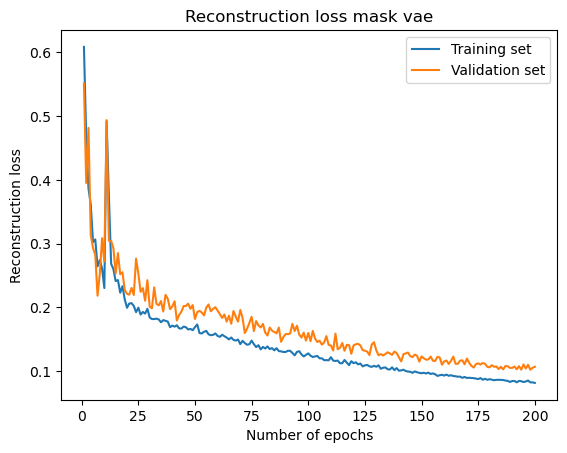

In [ ]:
plt.plot(range(1,len(vae_trainer.train_losses[0])+1), vae_trainer.train_losses[0])
plt.plot(range(1,len(vae_trainer.train_losses[0])+1), vae_trainer.valid_losses[0])
plt.xlabel('Number of epochs')
plt.ylabel('Reconstruction loss')
plt.title('Reconstruction loss mask vae')
plt.legend(['Training set', 'Validation set'])
plot_name = 'RECON_LOSS_'+str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + '_zdim.png'
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)

### Plot KLD loss

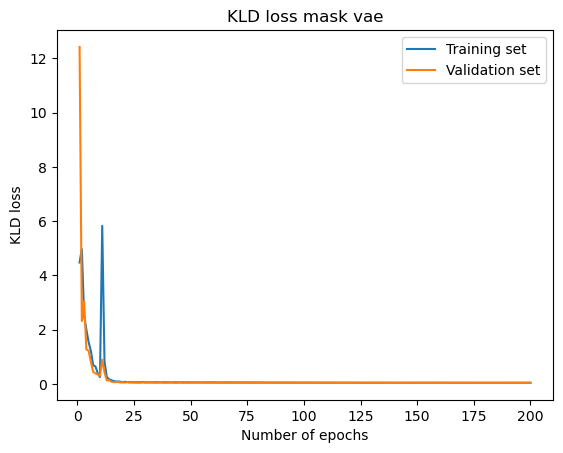

In [ ]:
plt.plot(range(1,len(vae_trainer.train_losses[1])+1), vae_trainer.train_losses[1])
plt.plot(range(1,len(vae_trainer.train_losses[1])+1), vae_trainer.valid_losses[1])
plt.ylabel('KLD loss')
plt.xlabel('Number of epochs')
plt.title('KLD loss mask vae')
plt.legend(['Training set', 'Validation set'])
plot_name = 'KLD_LOSS_'+str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + '_zdim.png'
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)

### Plot losses together (sum)

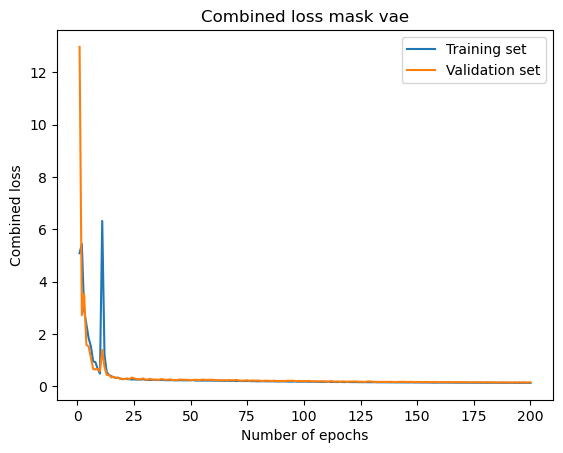

In [ ]:
plt.plot(range(1, len(vae_trainer.train_losses[0])+1), [sum(x) for x in zip(*vae_trainer.train_losses)])
plt.plot(range(1, len(vae_trainer.train_losses[0])+1), [sum(x) for x in zip(*vae_trainer.valid_losses)])
plt.ylabel('Combined loss')
plt.xlabel('Number of epochs')
plt.title('Combined loss mask vae')
plt.legend(['Training set', 'Validation set'])
plot_name = 'COMBINED_LOSS_'+str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + '_zdim.png'
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)

# Apply mask vae

In [ ]:
BEST_MODEL = Path(r"C:\Users\20182371\Documents\TUe\8DM20_CS_Medical_Imaging\DeepLearning_Project\progress_vaemask\200_epochs_16_zdim_orignalsize")
seed = 0

vae_model = VAE(spade=False).to(device)

model_dir = BEST_MODEL / "model.pth"
vae_model.load_state_dict(torch.load(model_dir))
vae_model.eval()

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=train_size)

partition = {
    "train": train_indx,
    "validation": valid_indx,
}

training_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE, empty_masks = True, transform = transform)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

first_indx = np.random.choice(np.arange(len(train_loader.dataset)), size=5, replace=False)
second_indx = first_indx+10
for i in range(len(second_indx)):
    if second_indx[i] > len(train_loader.dataset): 
        second_indx[i] = len(train_loader.dataset)-1

_ , first_mask_v = train_loader.dataset[first_indx]
_ , second_mask_v = train_loader.dataset[second_indx]
first_mask_v = first_mask_v.to(device)
second_mask_v = second_mask_v.to(device)

mu_first, logvar_first = vae_model.encoder(first_mask_v)
latent_z_first = utils.sample_z(mu_first, logvar_first)
            
mu_second, logvar_second = vae_model.encoder(second_mask_v)
latent_z_second = utils.sample_z(mu_second, logvar_second)
            


### Create interpolated mask image grid

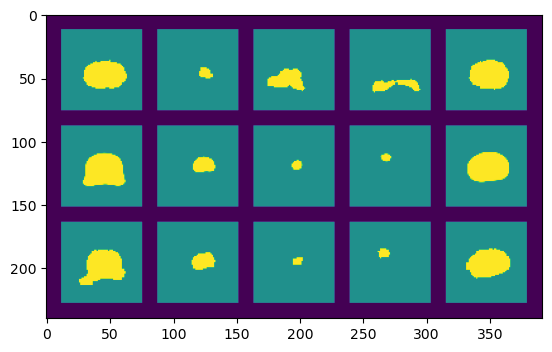

In [ ]:
weight = 0.9
gen_latent_z = latent_z_first + weight*(latent_z_second - latent_z_first)
generations  = vae_model.generator(gen_latent_z)
generations  = generations/2.0 + 0.5 

img_grid = make_grid(
                torch.cat([
                    first_mask_v.cpu(),
                    generations.cpu(),
                    second_mask_v.cpu()
                ]), 
                nrow=5, 
                padding=12, 
                pad_value=-1, )
    
plt.imshow(img_grid.numpy()[0] / 2.0 + 0.5)
plt.imsave(BEST_MODEL / f"interpolated_generations_{weight}.png", img_grid.numpy()[0] / 2.0 + 0.5)

### Create gif of interpolated masks 

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0


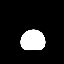

In [ ]:
first_indx = np.random.choice(np.arange(len(train_loader.dataset)), size=1, replace=False)
second_indx = np.random.choice(np.arange(len(train_loader.dataset)), size=1, replace=False)

#second_indx = first_indx+10
#for i in range(len(second_indx)):
#    if second_indx[i] > len(train_loader.dataset): 
#        second_indx[i] = len(train_loader.dataset)-1

_ , first_mask_v = train_loader.dataset[first_indx]
_ , second_mask_v = train_loader.dataset[second_indx]
first_mask_v = first_mask_v.to(device)
second_mask_v = second_mask_v.to(device)

mu_first, logvar_first = vae_model.encoder(first_mask_v)
latent_z_first = utils.sample_z(mu_first, logvar_first)
            
mu_second, logvar_second = vae_model.encoder(second_mask_v)
latent_z_second = utils.sample_z(mu_second, logvar_second)

images = []
for i in range(0,11,1):
    gen_latent_z = latent_z_first + (i/10)*(latent_z_second - latent_z_first)
    generations  = vae_model.generator(gen_latent_z)
    generations  = generations/2.0 + 0.5 
    
    images.append(np.array(generations.squeeze().detach().cpu()))

    
imageio.mimsave(BEST_MODEL / 'generations.gif', images, fps=10)

#did not know how to display a gif in jupyter notebook so the code below is from ChatGTP 
from IPython.display import HTML
from base64 import b64encode

gif = open(BEST_MODEL / 'generations.gif','rb').read()
#HTML(f"<img src='data:image/gif;base64,{b64encode(gif).decode('utf-8')}' />")
HTML(f"<img src='data:image/gif;base64,{b64encode(gif).decode('utf-8')}' style='width:600px;height:450px;'/>")